Outputs for data_east/cases:
          system_cost           carbon system_capacity wave_capacity  \
0    2707664519.52402   8765161.472069    41962.095916   6244.270245   
1    2879133016.84386  12003064.498557    47564.662252    872.011385   
2   2889863123.901674  12320130.362389    49308.445259           0.0   
3   2889863123.901679  12320130.362389    49308.445259           0.0   
4   2889863123.901677  12320130.362389    49308.445259           0.0   
5   2212278355.012809   5970976.208842    38916.425918  12883.853505   
6   2247468373.027168   5956859.447071    39027.273225  12849.063406   
7   2282329923.921812   6041397.763489    39016.063432  12711.719216   
8   2316494102.506675   6254581.466494    39129.667584  12262.895955   
9   2349450197.593555   6416447.726787     39236.87739  11949.513502   
10  2380915063.699014   6694963.881563    39685.718536  11047.372845   
11  2410686170.500953   7052069.722734    39563.300513  10766.654794   
12  2439700953.571717   7481903.418

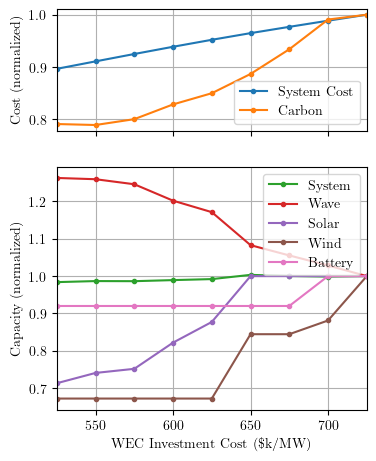

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

location = 'data_east'
inputs = pd.read_csv(os.path.join(location,'scenario_input.csv'))
all_loc_case_folders = [os.path.join(location,'cases')]
output_cols = ['system_cost', 'carbon', 'system_capacity','wave_capacity', 'solar_capacity', \
               'onshore_wind_capacity', 'offshore_wind_capacity', 'battery_capacity'] 
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)
output_scale = {'system_cost': 1e7, 'carbon': 1e4, 'system_capacity': 100, \
                'wave_capacity': 100, 'solar_capacity': 100, \
                'onshore_wind_capacity': 100, 'offshore_wind_capacity': 100, \
                'battery_capacity': 100}

wave_name = 'wave'
solar_name = ['utilitypv','solar_photovoltaic']
onshore_wind_name = ['onshore_wind','landbasedwind']
offshore_wind_name = ['offshore_wind','offshorewind']
battery_name = ['battery','batteries']

plt.style.use("paper.mplstyle")

for this_loc_cases_folder in all_loc_case_folders:
    for case in np.arange(1,len(inputs)+1):
        idx = case - 1
        case_result_folder = os.path.join(this_loc_cases_folder,'Case_'+str(case),'results','results_p1')
        cost_file     = os.path.join(case_result_folder,'costs.csv')
        carbon_file   = os.path.join(case_result_folder,'emissions.csv')
        capacity_file = os.path.join(case_result_folder,'capacity.csv')
        revenue_file  = os.path.join(case_result_folder,'NetRevenue.csv')

        system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
        carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
        capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
    
        system_cost = system_cost_df['Total'].loc['cTotal']
        carbon = carbon_df['Total'].loc['AnnualSum']
        system_capacity = capacity_df['EndCap'].loc['Total']

        wave_idx = capacity_df.index.str.contains(wave_name, regex=True)
        wave_capacity = capacity_df['EndCap'].loc[wave_idx].sum()
        pct_wave_capacity = wave_capacity / system_capacity

        solar_idx = capacity_df.index.str.contains('|'.join(solar_name), regex=True)
        solar_capacity = sum(capacity_df['EndCap'].loc[solar_idx])
        pct_solar_capacity = solar_capacity / system_capacity

        onshore_wind_idx = capacity_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
        onshore_wind_capacity = sum(capacity_df['EndCap'].loc[onshore_wind_idx])
        pct_onshore_wind_capacity = onshore_wind_capacity / system_capacity

        offshore_wind_idx = capacity_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
        offshore_wind_capacity = sum(capacity_df['EndCap'].loc[offshore_wind_idx])
        pct_offshore_wind_capacity = offshore_wind_capacity / system_capacity

        battery_idx = capacity_df.index.str.contains('|'.join(battery_name), regex=True)
        battery_capacity = sum(capacity_df['EndCap'].loc[battery_idx])
        pct_battery_capacity = battery_capacity / system_capacity

        outputs.loc[idx] = [system_cost, carbon, system_capacity,\
                            wave_capacity, solar_capacity, onshore_wind_capacity,\
                            offshore_wind_capacity, battery_capacity]

    outputs.reset_index(drop=True, inplace=True)
    print(f"Outputs for {this_loc_cases_folder}:")
    print(outputs)

    # extract inputs
    wec_cost_str = inputs.wave_cost.values
    wec_cost = np.array([float(c.rsplit('_')[-1]) for c in wec_cost_str])
    print(f"Weccost: {wec_cost}")
    wave_variability = inputs.wave_variability.values
    power_lim = np.array([float(v.rsplit('_')[-1]) for v in wave_variability])
    omega_n   = np.array([float(v.rsplit('_')[-3]) for v in wave_variability])
    zeta      = np.array([float(v.rsplit('_')[2])  for v in wave_variability])

    # determine size for reshaping
    num_costs = len(np.unique(wec_cost))
    num_power_limits = len(np.unique(power_lim))
    size_tuple = (num_costs, num_power_limits)

    # reshape inputs for plotting
    wec_cost = np.reshape(wec_cost, size_tuple)
    power_lim = np.reshape(power_lim, size_tuple)
    # ignore omega_n and zeta for now, not used in plotting

    # hardcoded based on result - in the future do this programatically
    x = 250/8
    points = np.array([[300+x,   0.03],
                       [300-x,   0.03],
                       [300-x,   0.05],
                       [300-3*x, 0.05],
                       [300-3*x, 0.09],
                       [300-5*x, 0.09],
                       [300-5*x, 0.11],
                       [300+x,   0.11],
                       [300+x,   0.03]])
    show_all_x = False
    if show_all_x:
        ok_low = min(wec_cost)
        ok_high = max(wec_cost)
    else:
        ok_low = 525
        ok_high = 725
    ok_idx = (wec_cost >= ok_low) & (wec_cost <= ok_high) # results outside this range look weird
    if np.any(np.array(size_tuple)==1):
        # line plot
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4,5.2), sharex=True, height_ratios=[1, 2])
        next(ax[1]._get_lines.prop_cycler)
        next(ax[1]._get_lines.prop_cycler) # start capacity plot at third color to not overlap with cost plot
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            y_units = False
            if y_units:
                scale = 1/output_scale[output]
            else:
                scale = 1/output_reshaped[wec_cost==725] # normalize by end of graph
            if 'capacity' in output:
                ax_idx = 1
                label_slice = slice(0, -1)
            else:
                ax_idx = 0
                label_slice = slice(None)
            if 'offshore_wind_capacity' not in output:
                val = output_reshaped.astype(float)*scale
                label_str = ' '.join(output.rsplit('_')[label_slice]).title()
                label_str = label_str.replace('Onshore ', '')
                ax[ax_idx].plot(wec_cost[ok_idx], val[ok_idx], '.-', label=label_str)
        
        if y_units:
            units_cost = '(\$M)' # fixme this should depend on scale and is probably inaccurate for the current scale
            units_capacity = '(MW)'
        else:
            units_cost = '(normalized)'
            units_capacity = '(normalized)'
        ax[1].set_xlabel('WEC Investment Cost (\$k/MW)')
        ax[0].set_ylabel('Cost ' + units_cost)
        ax[1].set_ylabel('Capacity ' + units_capacity)
        plt.xlim([ok_low, ok_high])
        ax[0].legend()
        ax[1].legend()
        ax[0].grid()
        ax[1].grid()
    else:
        # contour plots
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            fig, ax = plt.subplots()
            plt.pcolormesh(wec_cost, power_lim, output_reshaped.astype(float))
            #plt.plot(points[:,0],points[:,1],'r')
            plt.title(output)
            plt.xlabel('WEC Investment Cost ($k/MW)')
            plt.ylabel('WEC Fractional Power Limit')
            plt.colorbar()
    plt.savefig("CEM_cost_sweep.pdf", format="pdf", bbox_inches="tight")
    plt.show()
      
